In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from case_studies import *

#uncomment for environments ike WSL that have no gui
#import matplotlib
#matplotlib.use('agg')


def conjugate_gradients(Q,g,epsilon):
    """
    Implements the Conjugate Gradient function that finds the approximate minimum of the function

    f(x) = 1/2 x^TQx + g^Tx

    Arguments:
    Q: A nxn positive definite matrix
    g: A n vector
    epsilon: the tolerance, the algorithm terminates when |grad f(x)|<epsilon

    Returns:
    x_k: the approximate optimum 
    x_k_history: A list of solution candidates x_k computes by CG
    """
    x_k = np.zeros(g.shape[0]) #algorithm starts at 0
    x_k_history=[x_k.copy()] #history of x values computed
    
    # Algorithm 5: Conjugate Gradients
    grad_k = g.copy()          # ∇f0 = g
    p_k = -grad_k              # p0 = -∇f0

    while True:
        Qp_k = Q @ p_k
        alpha_k = -(p_k @ grad_k) / (p_k @ Qp_k)   # αk = -(p_k^T ∇fk) / (p_k^T Q p_k)
        x_k = x_k + alpha_k * p_k                    # x_{k+1} = x_k + α_k p_k
        grad_k_next = Q @ x_k + g                    # ∇f_{k+1} = Q x_{k+1} + g
        x_k_history.append(x_k.copy())

        if np.linalg.norm(grad_k_next) < epsilon:    # stop if ||∇f_{k+1}|| < ε
            break

        # p_{k+1} = -∇f_{k+1} + (∇f_{k+1}^T Q p_k) / (p_k^T Q p_k) * p_k
        beta_k = (grad_k_next @ Qp_k) / (p_k @ Qp_k)
        p_k = -grad_k_next + beta_k * p_k
        grad_k = grad_k_next
        
    return x_k, x_k_history


numerical difference: 8.288701342795902e-14
grad norm: 9.107888054159617e-12


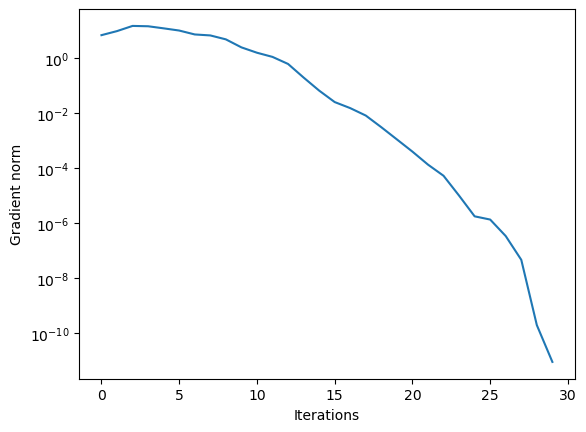

In [5]:
#setup problem 
n=50
epsilon=1.e-10
Q=np.random.randn(n,n//2)
Q=Q@Q.T +np.eye(n)
g = np.random.randn(n)

#analytical solution
solution = -np.linalg.inv(Q)@g 

#run algorithm
solution_cg, history = conjugate_gradients(Q,g,epsilon)

#test for correctness
print("numerical difference:", np.linalg.norm(solution-solution_cg))
grad_cg_sol = Q@solution_cg + g
print("grad norm:", np.linalg.norm(grad_cg_sol))

#plot the history
history_grad = [np.linalg.norm(Q@x + g) for x in history]
plt.semilogy(history_grad)
plt.ylabel("Gradient norm")
plt.xlabel("Iterations")
plt.savefig("results_cg.png")

In [ ]:
def steepest_descent_wrapper(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    xs = []
    grad_norms = []
    i = 0
    b = 1
    x_current = x0.copy()
    def bt_LS(x, b, p_k):
        """Backtracking line search"""
        a = b
        while f(x + a*p_k) > f(x) + c1*a*df(x).T@p_k:
            a = rho*a
        return a
    while i < max_iter:
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)
        
        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5*epsilon))    
        if grad_norm < epsilon:
            break
        p_k = -grad
        a_k = bt_LS(x_current, b, p_k)
        x_current = x_current + a_k*p_k
        i += 1
        b = a_k/rho
    return np.array(xs), np.array(grad_norms)


def newton_backtracking_eigenvalue(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    """
    Newton's Method following lecture slides pseudocode exactly.
    Uses eigenvalue modification: H_modified = Σ (1/|λᵢ|) vᵢvᵢᵀ
    
    This matches Algorithm 4 from the slides.
    """
    xs = []
    grad_norms = []
    
    i = 0
    b = 1
    x_current = x0.copy()
    
    def bt_LS(x, b, p_k):
        """Backtracking line search"""
        a = b
        while f(x + a*p_k) > f(x) + c1*a*df(x).T@p_k:
            a = rho*a
        return a
    
    def compute_newton_direction_eigenvalue(H, g):
        """
        Compute Newton direction following lecture slides.
        
        If H is positive definite: p = -H⁻¹g
        Else: Compute eigenvalues λᵢ and eigenvectors vᵢ
              H_modified = Σ (1/|λᵢ|) vᵢvᵢᵀ
              p = -H_modified · g
        """
        # Check if positive definite via Cholesky
        try:
            L = np.linalg.cholesky(H)
            y = np.linalg.solve(L, -g)
            p = np.linalg.solve(L.T, y)
            return p
        except np.linalg.LinAlgError:
            # H is not positive definite - use eigenvalue modification
            eigenvalues, eigenvectors = np.linalg.eigh(H)
            
            # Reconstruct with absolute values: H = Σ (1/|λᵢ|) vᵢvᵢᵀ
            # This is equivalent to: H_modified = V · diag(1/|λ|) · Vᵀ
            abs_inv_eigenvalues = 1.0 / np.abs(eigenvalues)
            
            # Compute H_modified · g efficiently without forming full matrix
            # H_modified · g = V · diag(1/|λ|) · Vᵀ · g
            temp = eigenvectors.T @ g  # Vᵀ · g
            temp = abs_inv_eigenvalues * temp  # diag(1/|λ|) · (Vᵀ · g)
            p = -(eigenvectors @ temp)  # -V · result
            
            return p
    
    while i < max_iter:
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)
        
        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5*epsilon))
        
        if grad_norm < epsilon:
            break
        
        # Compute Hessian and get Newton direction
        hess = Hf(x_current)
        p_k = compute_newton_direction_eigenvalue(hess, grad)
        
        # Backtracking line search
        a_k = bt_LS(x_current, b, p_k)
        x_current = x_current + a_k*p_k
        i += 1
        b = a_k/rho
    
    return np.array(xs), np.array(grad_norms)







In [ ]:
def inexact_newton(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    """
    Inexact Newton's Algorithm (Algorithm 6).
    Uses conjugate gradients to approximately solve the Newton system,
    with a forcing sequence eta_k that adapts to the gradient norm.

    Arguments:
    f       : objective function
    df      : gradient of f
    Hf      : Hessian of f
    x0      : starting point
    max_iter: maximum number of iterations
    epsilon : stopping tolerance (stop when ||∇f(x)|| < epsilon)
    rho     : backtracking factor (0 < rho < 1)
    c1      : sufficient decrease constant (0 < c1 < 1)

    Returns:
    xs          : array of iterates x_k
    grad_norms  : array of gradient norms at each iterate
    """
    xs = []
    grad_norms = []

    x_current = x0.copy()

    def bt_LS(x, p_k):
        """Backtracking line search starting from alpha=1.0"""
        a = 1.0
        while f(x + a * p_k) > f(x) + c1 * a * df(x) @ p_k:
            a = rho * a
        return a

    for k in range(max_iter):
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)

        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5 * epsilon))

        if grad_norm < epsilon:
            break

        # Forcing sequence: eta_k = min(1/2, sqrt(||∇f(x_k)||))
        eta_k = min(0.5, np.sqrt(grad_norm))
        # Inner tolerance: epsilon_k = eta_k * ||∇f(x_k)||
        epsilon_k = eta_k * grad_norm

        # Approximately solve Newton system H_k * p_k ≈ -∇f(x_k) via CG
        H = Hf(x_current)
        p_k, _ = conjugate_gradients(H, grad, epsilon_k)

        # Backtracking line search starting from alpha=1.0
        a_k = bt_LS(x_current, p_k)
        x_current = x_current + a_k * p_k

    return np.array(xs), np.array(grad_norms)
